Technion CS Course: 236330 Introduction to Numerical Optimization

In [48]:
import numpy as np
import numpy.linalg as la
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

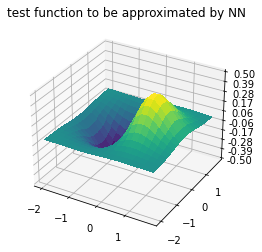

In [49]:
"""
test function to approximate by Neural Network
R^2 -> R with input x1, x2
"""
def func(x1, x2):
    return x1*np.exp(-(x1**2+x2**2))


# Plot the function to be approximated by the Neural Network


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(-2, 2, 0.2)
Y = np.arange(-2, 2, 0.2)
X, Y = np.meshgrid(X, Y)
Z = np.array(list(map(func, X, Y)))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='viridis',
                      linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.5, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

plt.title("test function to be approximated by NN")
plt.show()

In [50]:
""" 
tanh activation function
@param x R -> R: scalar input/output
"""
def activate(x):
    return np.tanh(x)

"""
derivative of the activation function @activate
"""
def d_activate(x):
    return 1/(np.cosh(x)**(2))

In [51]:
class W:
    """
    paramter class:
    layer weights W_x matrices and biases b_x
    """
    def __init__(self):
        self.W_1 = np.random.rand(2, 4)
        self.W_2 = np.random.rand(4, 3)
        self.W_3 = np.random.rand(3, 1)
        self.b_1 = np.random.rand(4,)
        self.b_2 = np.random.rand(3,)
        self.b_3 = np.random.rand()

    def flattenParams(self):
        self.vec = self.W_3.flatten()
        self.vec = np.append(self.vec, self.b_3)
        self.vec = np.append(self.vec, self.W_2.flatten())
        self.vec = np.append(self.vec, self.b_2.flatten())
        self.vec = np.append(self.vec, self.W_1.flatten())
        self.vec = np.append(self.vec, self.b_1.flatten())
        return self.vec 
    
    def fromVector(self, vec):
        """
        set fields from vector, reshape necessary
        """
        self.W_3 = np.reshape(vec[0:3:1], (3,1))
        self.b_3 = vec[3]
        self.W_2 = np.reshape(vec[4:16:1], (4,3))
        self.b_2 = vec[16:19:1]
        self.W_1 = np.reshape(vec[19:27:1], (2,4))
        self.b_1 = vec[27:31]

        

In [52]:
def loss_prime(x,y):
    """
    1.derivative of the quadratic loss function
    """
    return 2*(x-y)

In [53]:
class NeuralNetwork:
    def __init__(self, W):          
        self.input          = np.zeros((2,0))
        self.y              = 0
        self.param           = W
        self.loss       = 0
        
    def feedforward(self):
        self.layer1 = activate(self.param.W_1.T@self.input + self.param.b_1)
        #print("layer 1: ", self.layer1)
        self.layer2 = activate(self.param.W_2.T@self.layer1 + self.param.b_2)
        #print("layer 2: ", self.layer2)
        self.output = (self.param.W_3.T @ self.layer2) + self.param.b_3
        #print("output: ", self.output)
    def backprop(self):
        """
        mathematical backpropagation of loss function gradients:
        starting at the output layer and backpropagates to first layer
        _x gradient with respect to the layers input
        _W gradient with respect to the layers weights
        _b gradient with respect to the layers bias 
        """

        self.d_output_x = loss_prime(self.output, self.y)*self.param.W_3
        self.d_output_W = self.layer2*loss_prime(self.output, self.y)
        self.d_output_b = loss_prime(self.output, self.y)
        #layer 2 gradients
        self.d_layer2_x = self.param.W_2 @ np.diag(d_activate(self.param.W_2.T @ self.layer1 + self.param.b_2)) @ self.d_output_x
        self.d_layer2_W = np.outer(self.layer1, self.d_output_x) @ np.diag(d_activate(self.param.W_2.T @ self.layer1 + self.param.b_2))
        self.d_layer2_b = np.diag(d_activate(self.param.W_2.T @ self.layer1 + self.param.b_2)) @ self.d_output_x
        # layer 1 gradients
        self.d_layer1_x = self.param.W_1 @ np.diag(d_activate(self.param.W_1.T @ self.input +self.param.b_1)) @ self.d_layer2_x
        self.d_layer1_W = np.outer(self.input, self.d_layer2_x) @ np.diag(d_activate(self.param.W_1.T @ self.input + self.param.b_1))
        self.d_layer1_b = np.diag(d_activate(self.param.W_1.T @ self.input + self.param.b_1)) @ self.d_layer2_x
        # debug check dimensions
        # print("shape dW3 = {} \n dW2 = {} \n dW1 = {}".format(self.d_output_W.shape, self.d_layer2_W.shape, self.d_layer1_W.shape))
        # print("shape db3 = {} \n db2 = {} \n db1 = {}".format(self.d_output_b.shape, self.d_layer2_b.shape, self.d_layer1_b.shape))

    def stack(self):
        self.grad = self.d_output_W.flatten()
        self.grad = np.append(self.grad, self.d_output_b.flatten())
        self.grad = np.append(self.grad, self.d_layer2_W.flatten())
        self.grad = np.append(self.grad, self.d_layer2_b.flatten())
        self.grad = np.append(self.grad, self.d_layer1_W.flatten())
        self.grad = np.append(self.grad, self.d_layer1_b.flatten())
        return self.grad 
    
    def training(self, x_data, y_data):
        self.y_training_out = np.array([])
        gradient = 0
        self.dataset = x_data, y_data
        for x, y_true in zip(x_data, y_data):
            self.input = x
            self.y = y_true
            self.feedforward()
            self.backprop()
            #print("loss during training = ",(self.output - self.y)**2)
            self.loss = self.loss + (self.output - self.y)**2
            gradient = gradient + self.stack()
            self.y_training_out = np.append(self.y_training_out, self.output)
        #print("len data", len(y_data))
        self.loss = self.loss/len(y_data)
        return gradient/len(y_data)
    
    def returnDataSet(self, x_data, y_data):
        out = np.array([])
        for x, y_true in zip(x_data, y_data):
            self.input = x
            self.y = y_true
            self.feedforward()
            out=np.append(out, self.output)
        return out
    def testNetwork(self, x_1, x_2):
        #print("x1 shape {} x2 shape {}".format(x_1.shape, x_2.shape))
        out = np. array([])
        for x1, x2 in zip(x_1, x_2):
            self.input = np.array([x1, x2])
            self.feedforward()
            out=np.append(out,self.output)
        return out





    def iterMinimizeW(self, new_W):
        """
        called by minimize function, get new Loss with updated W
        @param new_W in vectorized form, reshape and assignment necessary
        """
        #set new parameters
        self.param.fromVector(new_W)
        self.training(self.dataset[0], self.dataset[1])
        return self.loss

    def iterMinimizeGradient(self, new_W):
        """
        evaluates the total loss function gradient vector with respect new parameter vector new_W and existing dataset
        """
        #set new parameters
        self.param.fromVector(new_W)
        return self.training(self.dataset[0], self.dataset[1])


        

In [54]:

def generateTrainingData(n):
    x = np.random.rand(n,2)*4-2
    y = list(map(func, x[:,0], x[:,1]))
    return x, y

def generateTestSet(n):
    x = np.random.rand(n,2)*4-2
    return x[:,0], x[:,1]



In [55]:
#INIT NN model
#generate training data
x_1, y_1 = generateTrainingData(500)
#create initial parameters
W_input = W()

#instantiate Neural Network
myNet = NeuralNetwork(W_input)
#  init training
myNet.training(x_1, y_1)
#z_1 = myNet.testNetwork(x_1, y_1)
"""
BFGS the NN with respect to x, that is, grad0 is starting point, data set x is fixed, find minimum grad
"""
result = minimize(myNet.iterMinimizeW, myNet.param.flattenParams(), method='BFGS', jac=myNet.iterMinimizeGradient, tol=10**(-5))

#evaluation with test set
x1_test, x2_test = generateTestSet(200)
#z_training = myNet.testNetwork(x1_test, x2_test)
z_test = myNet.testNetwork(x1_test, x2_test)

## Data visualization

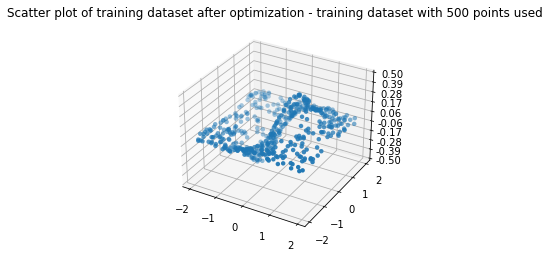

In [56]:
# Plot the function to be approximated by the Neural Network

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

#scatter plot test points
x, y = myNet.dataset
z = myNet.testNetwork(x[:,0], x[:,1])
ax.scatter(x[:,0], x[:,1], z,
                       linewidth=0)
# Customize the z axis.
ax.set_zlim(-0.5, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Scatter plot of training dataset after optimization - training dataset with 500 points used")
plt.show()




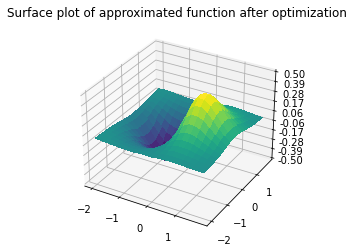

In [57]:
# plot approximated function by the Neural Network using the NN after training and optimization


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# get data from feedforwarding the mesh data through the optimized Neural Network
Z = np.array(list(map(myNet.testNetwork, X, Y)))
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='viridis',
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.5, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
plt.title("Surface plot of approximated function after optimization")
plt.show()
